In [1]:
import numpy as np 
import pandas as pd
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec


import seaborn as sns
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)



In [3]:
%%time
# These are the loaded dataframes that are calculated below

df_corr_all = pd.read_csv("data/int_pc_qvals_gcamp_dms.csv", index_col = 0) # .dropna(subset=['Q_dir_diff'])


df_trials = pd.read_csv("data/int_pc_qvals.csv", index_col = 0)


# update the gcamp values from strings --> arrays of floats 
df_src = df_corr_all

df_src['g_np'] = df_src['g_np'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_lp'] = df_src['g_lp'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_choice'] = df_src['g_choice'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_reward'] = df_src['g_reward'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))



CPU times: user 2.59 s, sys: 128 ms, total: 2.72 s
Wall time: 2.76 s


In [4]:
# some additional constants 

# for gcamp (dt = dt of gcamp recordings)
dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2
GCAMP_RANGE = np.arange(-1, 2, 1/dt)

# for trials in general 

NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

In [5]:
np.unique(df_corr_all.RecordLoc)

array(['DMS', 'DMS_CB'], dtype=object)

In [6]:
df_corr_DMS = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'DMS'])
df_corr_DMS_CB = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'DMS_CB'])


In [7]:
# get the cuts + the binnings 

# constants: 
AVG_TIME_COURSE = np.arange(15, 30) # time course to average over. 15:30 corresponds to 0 to 1.0 seconds at timelock
Q_BINS = 10
Q_BINS_QUANTILES = Q_BINS

for df_i in [df_corr_DMS, df_corr_DMS_CB]:

    df_i['bQ_dir_diff'] = pd.cut(df_i['Q_dir_diff'], Q_BINS)
    df_i['bQ_ch_diff'] = pd.cut(df_i['Q_ch_diff'], Q_BINS)

    # quantile cuts for raw Q values 
    df_i['bQ_chosen'] = pd.qcut(df_i['Q_chosen'], Q_BINS_QUANTILES)
    df_i['bQ_c'] = pd.qcut(df_i['Q_c'], Q_BINS_QUANTILES)

# Note that Q_i below is not the most accurate way of getting it 
# Q_DIR_DIFF = Q_C - Q_I 
# Q_I =  Q_C - Q_DIR_DIFF 
# however --> these are the averaged values of Q_C and Q_DIR_DIFF. If you eventually want Q_i, you'll want to derive it from the 
# 3K samples of Q_i, then average. 

# df_corr['bQ_i'] = pd.qcut(df_corr['Q_c'] - df_corr['Q_dir_diff'], Q_BINS_QUANTILES)


# Figure 1 and 2

Done


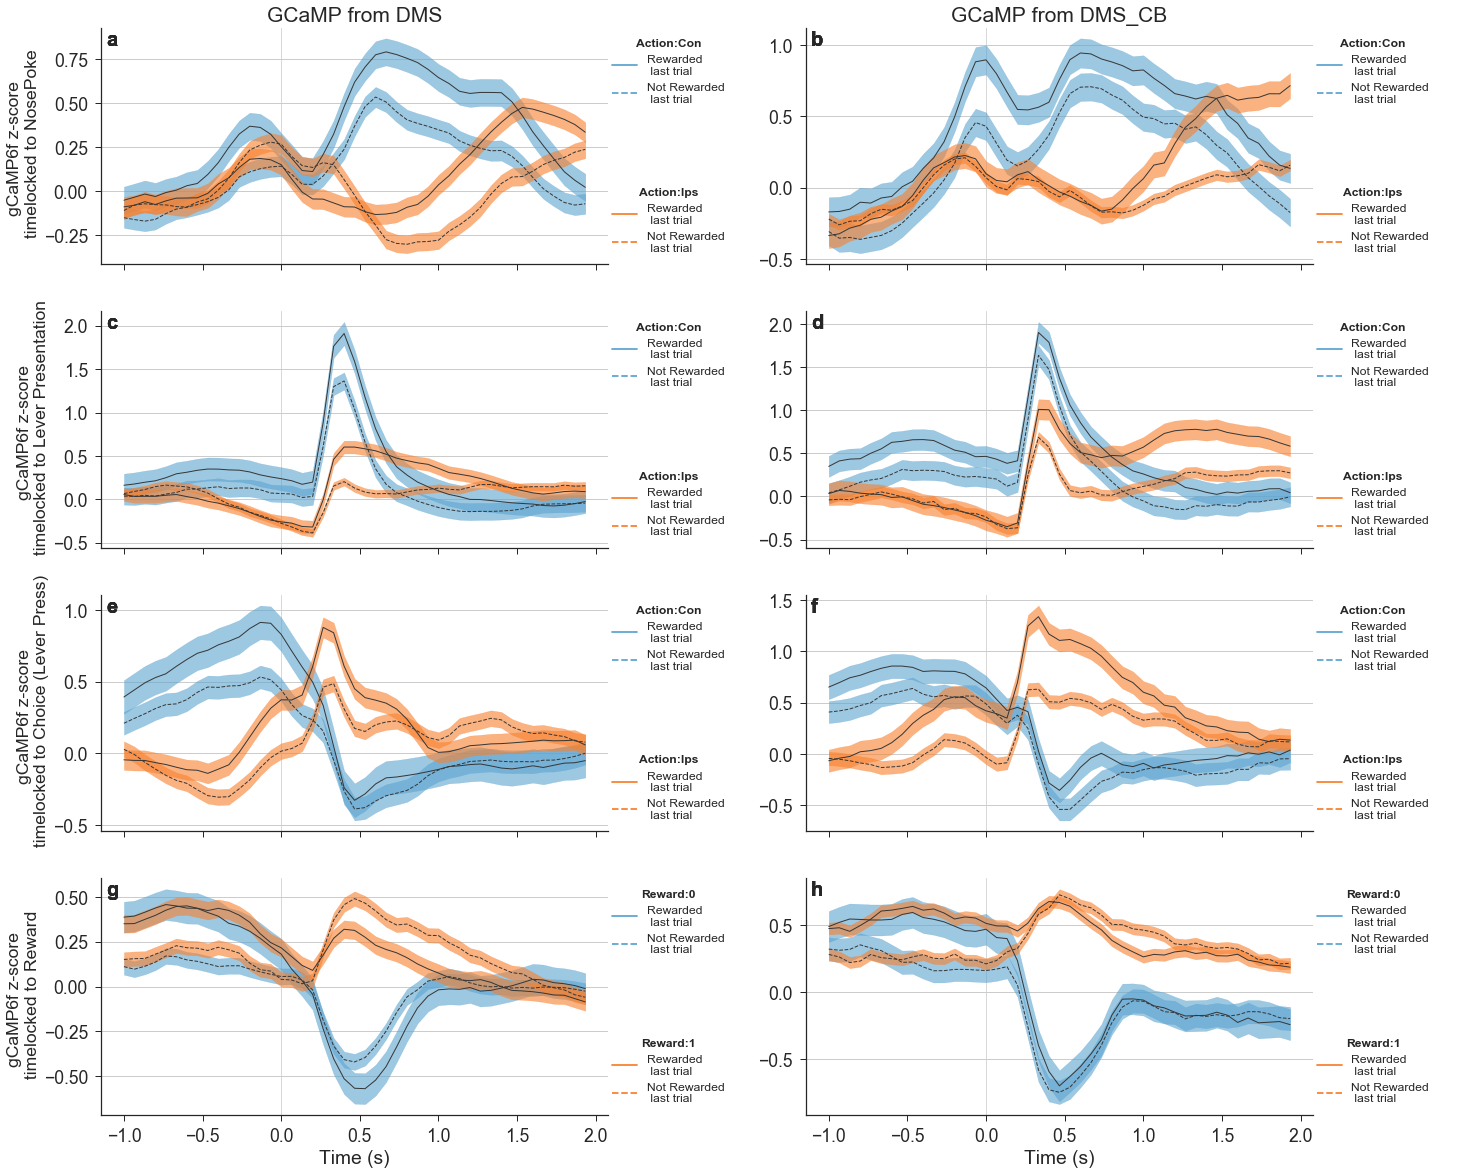

In [11]:
# RAW PLOT WITH LEGENDS 
sns.set_style('ticks')
Q_to_plot = 'Q_ch_diff'
Q_to_plot_name = 'Difference of Q val of \n chosen and unchosen'
# ylims = [[-0.45, 0.9], [-0.55, 2.0], [-0.55, 1.0], [-0.65, 0.66]]
figure = plt.figure(figsize=(24, 20))
subfigs = np.array([['a', 'b'],['c', 'd'], ['e', 'f'], ['g', 'h']])
gs = gridspec.GridSpec(4, 4,
                       width_ratios=[9, 1, 9, 1])

gs.update(wspace=0.25)

palettes = [ 'Blues', 'Oranges']

lines = np.arange(2)
line_styles = ['--', '-']
for j, df_i in enumerate([df_corr_DMS, df_corr_DMS_CB]):
    qlims = np.unique(df_i['b' + Q_to_plot].dropna())

    

    for i, [timelocked, tl_name] in enumerate(zip(['g_np', 'g_lp', 'g_choice', 'g_reward'], 
                                                           ['NosePoke', 'Lever Presentation', 'Choice (Lever Press)', 'Reward'])):

        if tl_name == 'Reward':
            categories = [0, 1]
            column = 'Reward'
        else:
            categories = ['Con', 'Ips']
            column = 'Action'
            
            
        
        
        lax2 = plt.subplot(gs[i, j*2 + 1])

        for p_i, [subcat,palette] in enumerate(zip(categories, palettes)):
            color_palette = sns.color_palette(sns.color_palette(palette, len(qlims)))
  

            ln1, = lax2.plot([], color = color_palette[5], linestyle = line_styles[1], label = 'Rewarded\n last trial')
            ln2, = lax2.plot([], color = color_palette[5], linestyle = line_styles[0], label = 'Not Rewarded\n last trial')
                       
            lgd = plt.legend(handles = [ln1, ln2], fontsize = 'xx-small', loc= (p_i * 3 + 1), title = column + ':' + str(subcat)) #  bbox_to_anchor=(0.5,0.7))
            plt.setp(lgd.get_title(),fontsize='xx-small', weight = 'bold')

            if p_i == 0:
                lax2.add_artist(lgd)

            lax2.axis('off')


        ax = plt.subplot(gs[i, j*2])


        for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
            df_src = df_i[(df_i[column] == subcat) & (df_i['Stay/Leave'] == 'stay')]
            color_palette = sns.color_palette(sns.color_palette(palette, len(qlims)))


            for l_i, col in zip(lines, color_palette):


                gcamp = np.vstack(df_src[(df_src['Reward_last'] == l_i)][timelocked])
                x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                y = np.mean(gcamp, axis = 0)
                col = color_palette[5]

                error = np.std(y, axis = 0) / np.sqrt(NS)
                ax.plot(x, y, color = '#363737', linewidth = 1, ls = line_styles[l_i])
                ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
                
                # title
                if i == 0:
                    plt.title('GCaMP from ' + np.unique(df_i['RecordLoc'])[0])

                # add subfig label
                ax.annotate(subfigs[i, j], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                
                # y axis 
#                 tick_interval = 0.25 
#                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
        
#                 plt.ylim(ylims[i])
#                 if i == 1 or i == 2: 
#                     n = 2  # Keeps every nth label
#                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
                if j == 0:
                    plt.ylabel('gCaMP6f z-score \n timelocked to ' + tl_name, size = 'small')

                # x axis 
                if i == 3:
                    plt.xlabel('Time (s)')
                else:
                    plt.xlabel('')
                    ax.xaxis.set_ticklabels([])
                
                # grid lines
                ax.yaxis.grid(True)
                ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'




# plt.tight_layout(w_pad = 0.001, h_pad = 0.2)
sns.despine()

plt.savefig('figs/dms_all_gcamp', dpi=180)
# plt.close()
print('Done')


In [ ]:
# RAW PLOT WITH LEGENDS 
sns.set_style('ticks')
Q_to_plot = 'Q_ch_diff'
Q_to_plot_name = 'Difference of Q value of \n chosen and unchosen'
ylims = [[-0.5, 2.2], [-0.5, 2.2]]
figure = plt.figure(figsize=(12, 15))
subfigs = np.array(['a', 'b', 'c'])
gs = gridspec.GridSpec(4, 3,
                       width_ratios=[9, 0.2, 0.2], height_ratios = [1, 0.1, 0.8, 1])



gs.update(wspace=0.25)

qlims = np.unique(df_corr_DMS['b' + Q_to_plot].dropna())
line_styles = ['--', '-']


for i, [src, lines] in enumerate(zip(['gcamp', 'qval'], [np.arange(2), qlims])):
    

    j = 0
    timelocked = 'g_lp'
    tl_name = 'Lever Presentation' 
    palettes = [ 'Blues', 'Oranges']

        
    if tl_name == 'Reward':
        categories = [1, 0]
        column = 'Reward'
        cat_names = ['CS+', 'CS-']
    else:
        categories = ['Con', 'Ips']
        column = 'Action'
        cat_names = categories
            
                    
    # legend plotting 1. colorbar for the q values 
                
        
    lax2 = plt.subplot(gs[i, -2])

    for p_i, [subcat,palette] in enumerate(zip(cat_names, palettes)):
 
        color_palette = sns.color_palette(palette, len(qlims))

  
        cmap = ListedColormap(color_palette.as_hex())
        bounds = [x.left for x in qlims] + [qlims[-1].right]
        norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))
        if i == 1:

            lax = plt.subplot(gs[i + 1, j + 1 + p_i])
            dummy_plot = lax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
            lax.cla()
            cbar = plt.colorbar(dummy_plot, cax = lax)

                
            cbar.ax.set_title(subcat, size = 'x-small')


            if p_i == 0:
                cbar.ax.set_yticklabels([])
                cbar.set_label(Q_to_plot_name, size =  12, weight = 'bold', labelpad=-50, y=0.5, rotation=90)
            if p_i == 1:
                cbar.ax.tick_params(labelsize = 10)
#                     cbar.ax.tick_params(axis='y', direction='inout', left = False, right = True)
        if i == 0:
                
            ln1, = lax2.plot([], color = color_palette[5], linestyle = line_styles[1], label = 'Rewarded\n last trial')
            ln2, = lax2.plot([], color = color_palette[5], linestyle = line_styles[0], label = 'Not Rewarded\n last trial')
                
            lgd = plt.legend(bbox_to_anchor=(1.5, 0.5), handles = [ln1, ln2], 
                                 fontsize = 'x-small', loc= (p_i + 8), title = column + ':' + str(subcat)) #  bbox_to_anchor=(0.5,0.7))
            plt.setp(lgd.get_title(),fontsize='x-small', weight = 'bold')

            if p_i == 0:
                lax2.add_artist(lgd)

            lax2.axis('off')

    if i == 1:
        with sns.axes_style("white"):
            lax_title = plt.subplot(gs[1, 1:])
            lax_title.text(0.5, 0.5, column, size = 'x-small', weight = 'bold', ha = 'center')

            lax_title.axis('off')
            
    
    ax = plt.subplot(gs[i: (i * 2 + 1 ), j*3])



    for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
        df_src = df_corr_DMS[df_corr_DMS[column] == subcat]

        color_palette = sns.color_palette(palette, len(qlims))



        for l_i, col in zip(lines, color_palette):

            # plot gcamps
            if src == 'qval':
                x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                y = np.mean(df_src[(df_src[Q_to_plot] > l_i.left) & (df_src[Q_to_plot] <= l_i.right)][timelocked], 0)
                ls_i = '-'
                lw = 0.5
            elif src == 'gcamp':
                gcamp = np.vstack(df_src[(df_src['Reward_last'] == l_i) & (df_src['Stay/Leave'] == 'stay')][timelocked])
                x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                y = np.mean(gcamp, axis = 0)
                col = color_palette[5]
                lw = 1.5
                ls_i = line_styles[l_i]

            error = np.std(y, axis = 0) / np.sqrt(NS)
            ax.plot(x, y, color = '#363737', linestyle = ls_i, linewidth = lw)
            ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
                
                # title
#                 if i == 0:
#                     plt.title('GCaMP filtered with ' + src)

                # add subfig label
            ax.annotate(subfigs[i], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                
#                 # y axis 
#                 tick_interval = 0.25 
#                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
        
            plt.ylim(ylims[i])
#                 if i == 1 or i == 2: 
#                     n = 2  # Keeps every nth label
#                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
            if j == 0:
                plt.ylabel('z-scored gCaMP6f', size = 'small')

                # x axis 

            plt.xlabel('')
            ax.xaxis.set_ticklabels([])
                
                # grid lines
            ax.yaxis.grid(True)
            ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'

i = 2
ax = plt.subplot(gs[-1, 0])
lax = plt.subplot(gs[-1, 1:])
Q_vals = 'Q_ch_diff'

ylim = [-1.2, 1.2]
sig = [0.05, 0.01, 0.001]
pval_gap = 0.08 

df_src = pd.read_csv('data/DMS/_lever_m.csv')
df_src = df_src[df_src['names']!= '(Intercept)']
df_src.loc[df_src['names'] == Q_vals + ':ActionIps', 'Estimate'] = -df_src[df_src['names'] == Q_vals + ':ActionIps'].Estimate
df_src.loc[df_src['names'] == 'ActionIps', 'Estimate'] = -df_src[df_src['names'] == 'ActionIps'].Estimate
        
        
num_var = len(np.unique(df_src['names']))
sns.lineplot(data=df_src, x = 'time', y = 'Estimate', hue = 'names', 
             ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))

for ln_i, [n, col] in enumerate(zip(df_src['names'][:num_var ], 
                                    sns.color_palette('tab10', num_var ))):
    df_i = df_src[df_src['names'] == n]
    ax.fill_between(df_i['time'], df_i['Estimate'] - df_i['Std. Error'], df_i['Estimate'] + df_i['Std. Error'], 
                             color = col, alpha = 0.6)
            
    if ((i == 3) and (j == 1)):
        pval_gap = 0.12
    for s_i, s in enumerate(sig):
        x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pr(>|t|)']  <= s]
        y = np.ones(len(x)) * -1 + ln_i * pval_gap

        ax.scatter(x, y, color = col, s = 5 + (20 * s_i))
        if n == 'Q_ch_diff:ActionIps':
            n = 'Difference of \nQ value of chosen \nx Action(Ipsi)'
        if n == 'Q_ch_diff':
            n = 'Difference of \nQ value of chosen'
        if n == 'ActionIps':
            n = 'Action(Ipsi)'
    lax.fill_between([], [], [], color = col, label = n)



l = 'upper center'
lgd = lax.legend(title = 'Normalized\nRegression\nVariables', 
                             fontsize = 'x-small', loc = l, bbox_to_anchor=(0.2, 1.0))
            
            

plt.setp(lgd.get_title(),fontsize='x-small', weight = 'bold')
lax.axis('off')



# add subfig label
ax.annotate(subfigs[i], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                

        
ax.set_ylim(ylim)

ax.set_ylabel('Estimates', size = 'small')
ax.set_xlabel('Time (s)')

                
ax.yaxis.grid(True)
ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'







    
# plt.tight_layout(w_pad = 0.001, h_pad = 0.2)
sns.despine()

# plt.savefig('figs/Fig3', dpi=200)
print('Done')


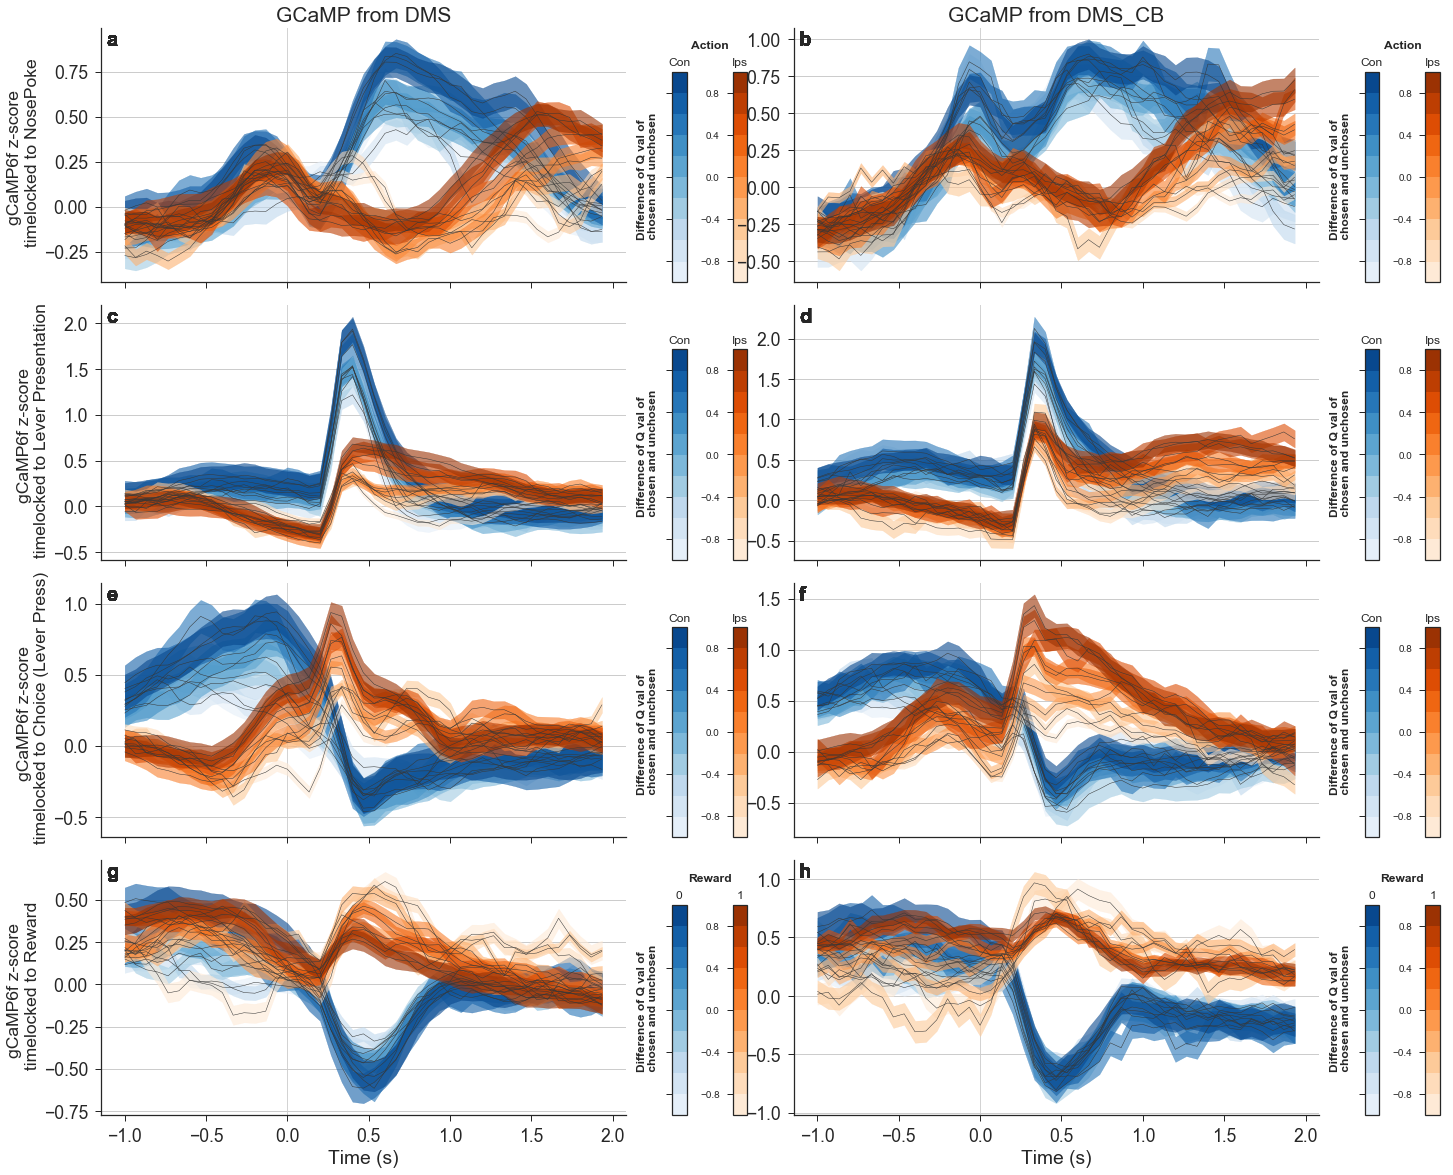

In [13]:
# RAW PLOT WITH LEGENDS 
sns.set_style('ticks')
Q_to_plot = 'Q_ch_diff'
Q_to_plot_name = 'Difference of Q val of \n chosen and unchosen'
# ylims = [[-0.45, 0.9], [-0.55, 2.0], [-0.55, 1.0], [-0.65, 0.66]]
figure = plt.figure(figsize=(24, 20))
subfigs = np.array([['a', 'b'],['c', 'd'], ['e', 'f'], ['g', 'h']])
gs = gridspec.GridSpec(8, 6,
                       width_ratios=[9, 0.25, 0.25, 9, 0.25, 0.25], height_ratios = [0.1, 1, 0.1, 1, 0.1, 1, 0.1, 1])

gs.update(wspace=0.25)

palettes = [ 'Blues', 'Oranges']

for j, df_i in enumerate([df_corr_DMS, df_corr_DMS_CB]):
    qlims = np.unique(df_i['b' + Q_to_plot].dropna())


    

    for i, [timelocked, tl_name] in enumerate(zip(['g_np', 'g_lp', 'g_choice', 'g_reward'], 
                                                           ['NosePoke', 'Lever Presentation', 'Choice (Lever Press)', 'Reward'])):

        if tl_name == 'Reward':
            categories = [0, 1]
            column = 'Reward'
        else:
            categories = ['Con', 'Ips']
            column = 'Action'
            
            
        
    # legend plotting 1. colorbar for the q values 
        if (i == 0 or i == 3):
            with sns.axes_style("white"):

                lax_title = plt.subplot(gs[i * 2, j * 3 + 1 : (j * 3 + 3)])
                lax_title.text(0.5, 0, column, size = 'xx-small', weight = 'bold', ha = 'center')

                lax_title.axis('off')
                
        
        

        for p_i, [subcat,palette] in enumerate(zip(categories, palettes)):
            color_palette = sns.color_palette(palette, len(qlims))
  
            cmap = ListedColormap(color_palette.as_hex())
            bounds = [x.left for x in qlims] + [qlims[-1].right]
            norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))

            lax = plt.subplot(gs[i*2 + 1, j * 3 + 1 + p_i])
            dummy_plot = lax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
            lax.cla()
            cbar = plt.colorbar(dummy_plot, cax = lax)

            cbar.ax.set_title(subcat, size = 'xx-small')


            if p_i == 0:
                cbar.ax.set_yticklabels([])
                cbar.set_label(Q_to_plot_name, size =  12, weight = 'bold', labelpad=-50, y=0.5, rotation=90)
            if p_i == 1:
                cbar.ax.tick_params(labelsize = 10)

        ax = plt.subplot(gs[i*2: (i * 2 + 2), j*3])


        for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
            df_src = df_i[df_i[column] == subcat]
            color_palette = sns.color_palette(sns.color_palette(palette, len(qlims)))


            for l_i, col in zip(qlims, color_palette):


                x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                y = np.mean(df_src[(df_src[Q_to_plot] > l_i.left) & (df_src[Q_to_plot] <= l_i.right)][timelocked], 0)
                

                error = np.std(y, axis = 0) / np.sqrt(NS)
                ax.plot(x, y, color = '#363737', linestyle = '-', linewidth = '0.5')
                ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
                
                # title
                if i == 0:
                    plt.title('GCaMP from ' + np.unique(df_i['RecordLoc'])[0])

                # add subfig label
                ax.annotate(subfigs[i, j], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                
                # y axis 
#                 tick_interval = 0.25 
#                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
        
#                 plt.ylim(ylims[i])
#                 if i == 1 or i == 2: 
#                     n = 2  # Keeps every nth label
#                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
                if j == 0:
                    plt.ylabel('gCaMP6f z-score \n timelocked to ' + tl_name, size = 'small')

                # x axis 
                if i == 3:
                    plt.xlabel('Time (s)')
                else:
                    plt.xlabel('')
                    ax.xaxis.set_ticklabels([])
                
                # grid lines
                ax.yaxis.grid(True)
                ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'




# plt.tight_layout(w_pad = 0.001, h_pad = 0.2)
sns.despine()

plt.savefig('figs/dms_all_qvals', dpi=180)
# plt.close()
# print('Done')


# Figure 3 

In [202]:
# RAW PLOT WITH LEGENDS 
sns.set_style('ticks')

ylim = [-1.2, 1.2]
figure = plt.figure(figsize=(24, 20))
subfigs = np.array([['a', 'b'],['c', 'd'], ['e', 'f'], ['g', 'h']])
sig = [0.05, 0.01, 0.001]
gs = gridspec.GridSpec(4, 4,
                       width_ratios=[9, 1.2, 9, 1])

gs.update(wspace=0.25)

pval_gap = 0.08 
palettes =  ['Blues', 'Reds']
lines = np.arange(2)

for j, recordloc in enumerate(['DMS', 'NaC']):

    

    for i, [timelocked, tl_name] in enumerate(zip(['nosepoke_m', 'lever_m', 'choice_m', 'reward_m'], 
                                                           ['NosePoke', 'Lever Presentation', 'Choice (Lever Press)', 'Reward'])):


        ax = plt.subplot(gs[i, j*2])
        lax = plt.subplot(gs[i, j*2 + 1])

        df_src = pd.read_csv('data/' + recordloc + '/' + timelocked + '.csv')
        df_src = df_src[df_src['names']!= '(Intercept)']
        
        
        num_var = len(np.unique(df_src['names']))
        sns.lineplot(data=df_src, x = 'time', y = 'Estimate', hue = 'names', ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))
        for ln_i, [n, col] in enumerate(zip(df_src['names'][:num_var ], sns.color_palette('tab10', num_var ))):
            df_i = df_src[df_src['names'] == n]
            ax.fill_between(df_i['time'], df_i['Estimate'] - df_i['Std. Error'], df_i['Estimate'] + df_i['Std. Error'], 
                             color = col, alpha = 0.6)
            
            if ((i == 3) and (j == 1)):
                pval_gap = 0.12
            for s_i, s in enumerate(sig):
                x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pr(>|t|)']  <= s]
                y = np.ones(len(x)) * -1 + ln_i * pval_gap

                ax.scatter(x, y, color = col, s = 5 + (20 * s_i))
            if n == 'Q_ch_diff:ActionIps':
                n = 'Difference of \nQ chosen value \nx Action(Ipsi)'
            if n == 'Q_ch_diff':
                n = 'Difference of \nQ chosen value'
            if n == 'ActionIps':
                n = 'Action(Ipsi)'
            lax.fill_between([], [], [], color = col, label = n)


        if j == 0:
            l = 'best'
        else:
            l = 'upper center'
        lgd = lax.legend(title = 'Regression\nVariables', fontsize = 'x-small', loc = l)
        plt.setp(lgd.get_title(),fontsize='x-small', weight = 'bold')
        lax.axis('off')


        # title
        if i == 0:
            ax.set_title('GCaMP from ' + recordloc)

        # add subfig label
        ax.annotate(subfigs[i, j], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                
                # y axis 
#                 tick_interval = 0.25 
#                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
        
        if (not ((i == 3) and (j == 1))):
            ax.set_ylim(ylim)
#                 if i == 1 or i == 2: 
#                     n = 2  # Keeps every nth label
#                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
        if j == 0:
            ax.set_ylabel('Variable Estimates for \n GCaMP6f timelocked \n to ' + tl_name, size = 'x-small')
        else:
            ax.set_ylabel('')
            # x axis 
        if i == 3:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
                
        # grid lines
        ax.yaxis.grid(True)
        ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'




# plt.tight_layout(w_pad = 0.001, h_pad = 0.2)
sns.despine()

plt.savefig('figs/Fig3', dpi=180)
plt.close()
print('Done')


Done


In [203]:
# RAW PLOT WITH LEGENDS 
sns.set_style('ticks')

ylim = [-1.2, 1.2]
figure = plt.figure(figsize=(24, 20))
subfigs = np.array([['a', 'b'],['c', 'd'], ['e', 'f'], ['g', 'h']])
sig = [0.05, 0.01, 0.001]
gs = gridspec.GridSpec(4, 4,
                       width_ratios=[9, 1.2, 9, 1])

gs.update(wspace=0.25)

pval_gap = 0.08 
palettes =  ['Blues', 'Reds']
lines = np.arange(2)

for j, recordloc in enumerate(['DMS', 'NaC']):

    

    for i, [timelocked, tl_name] in enumerate(zip(['nosepoke_m', 'lever_m', 'choice_m', 'reward_m'], 
                                                           ['NosePoke', 'Lever Presentation', 'Choice (Lever Press)', 'Reward'])):


        ax = plt.subplot(gs[i, j*2])
        lax = plt.subplot(gs[i, j*2 + 1])

        df_src = pd.read_csv('data/' + recordloc + '/_' + timelocked + '.csv')
        df_src = df_src[df_src['names']!= '(Intercept)']
        
        
        num_var = len(np.unique(df_src['names']))
        sns.lineplot(data=df_src, x = 'time', y = 'Estimate', hue = 'names', ax = ax, legend = False, palette = sns.color_palette('tab10', num_var ))
        for ln_i, [n, col] in enumerate(zip(df_src['names'][:num_var ], sns.color_palette('tab10', num_var ))):
            df_i = df_src[df_src['names'] == n]
            ax.fill_between(df_i['time'], df_i['Estimate'] - df_i['Std. Error'], df_i['Estimate'] + df_i['Std. Error'], 
                             color = col, alpha = 0.6)
            
            if ((i == 3) and (j == 1)):
                pval_gap = 0.12
            for s_i, s in enumerate(sig):
                x = (np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15))[df_i['Pr(>|t|)']  <= s]
                y = np.ones(len(x)) * -1 + ln_i * pval_gap

                ax.scatter(x, y, color = col, s = 5 + (20 * s_i))
            if n == 'Q_ch_diff:ActionIps':
                n = 'Difference of \nQ chosen value \nx Action(Ipsi)'
            if n == 'Q_ch_diff':
                n = 'Difference of \nQ chosen value'
            if n == 'ActionIps':
                n = 'Action(Ipsi)'
            lax.fill_between([], [], [], color = col, label = n)


        if j == 0:
            l = 'best'
        else:
            l = 'upper center'
        lgd = lax.legend(title = 'Normalized\nRegression\nVariables', fontsize = 'x-small', loc = l)
        plt.setp(lgd.get_title(),fontsize='x-small', weight = 'bold')
        lax.axis('off')


        # title
        if i == 0:
            ax.set_title('GCaMP from ' + recordloc)

        # add subfig label
        ax.annotate(subfigs[i, j], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                
                # y axis 
#                 tick_interval = 0.25 
#                 ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
        
        if (not ((i == 3) and (j == 1))):
            ax.set_ylim(ylim)
#                 if i == 1 or i == 2: 
#                     n = 2  # Keeps every nth label
#                     [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
        if j == 0:
            ax.set_ylabel('Variable Estimates for \n GCaMP6f timelocked \n to ' + tl_name, size = 'x-small')
        else:
            ax.set_ylabel('')
            # x axis 
        if i == 3:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
                
        # grid lines
        ax.yaxis.grid(True)
        ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'




# plt.tight_layout(w_pad = 0.001, h_pad = 0.2)
sns.despine()

plt.savefig('figs/Fig3_normalized', dpi=180)
plt.close()
print('Done')


Done


In [199]:

df_src = pd.read_csv('data/' + 'DMS'+ '/_' + timelocked + '.csv')

len(np.unique(df_src[df_src['df'].isnull()].time))

21

In [100]:
df_src['names'][:num_var]

0            (Intercept)
1              Q_ch_diff
2              ActionIps
3                 Reward
4    Q_ch_diff:ActionIps
Name: names, dtype: object

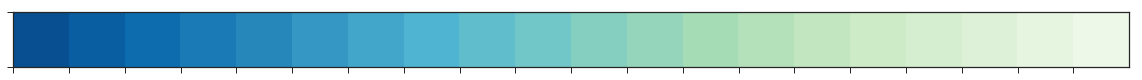

In [166]:
sns.palplot(sns.color_palette('GnBu_r', 20))

In [164]:
sns.palplot(sns.color_palette('YlOrRd_rd', 20))

ValueError: YlOrRd_rd is not a valid palette name

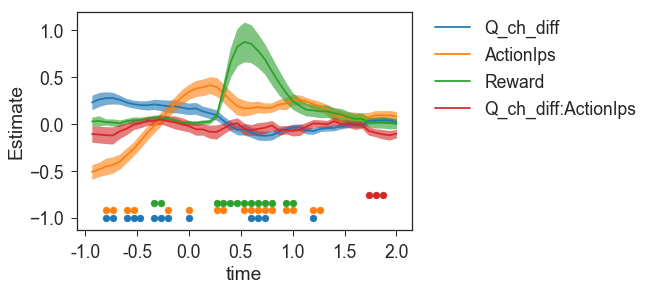

In [72]:
# sns.set_style('grid')
df_ch = pd.read_csv('data/regression1/reward_m.csv')
df_ch = df_ch[df_ch['names'] != '(Intercept)']
num_var = len(np.unique(df_ch['names']))
sns.lineplot(data=df_ch, x = 'time', y = 'Estimate', hue = 'names', palette = sns.color_palette('tab10', num_var ))
for i, [n, col] in enumerate(zip(df_ch['names'][:num_var ], sns.color_palette('tab10', num_var ))):
    df_i = df_ch[df_ch['names'] == n]
    plt.fill_between(df_i['time'], df_i['Estimate'] - df_i['Std. Error'], df_i['Estimate'] + df_i['Std. Error'], 
                     color = col, alpha = 0.6)
    x = (np.arange(45))[df_i['Pr(>|t|)']  <= 0.05]
    y = np.ones(len(x)) * -1 + i * 0.08
    
    plt.scatter(x, y, color = col)
    plt.xticks(np.arange(0, 50, 7.5), np.arange(-1, 3, 0.5))
    

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [53]:
x[df_i['Pr(>|t|)']  <= 0.001]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [56]:
len(df_i['Pr(>|t|)']  <= 0.001)

45

# Figure 1 (version 1)




In [7]:


figure = plt.figure(figsize=(36, 18))

for j, Q_to_plot in enumerate(['Q_dir_diff', 'Q_chosen', 'Q_ch_diff']):

    for i, [timelocked, tl_name, palette] in enumerate(zip(['g_np', 'g_lp', 'g_choice', 'g_reward'], 
                                                           ['NosePoke', 'Lever Presentation', 'Choice (Lever Press)', 'Reward'], 
                                                           ['Reds', 'Oranges','Purples', 'Greens'])):
        ax = plt.subplot2grid((4,3),(i, j),rowspan=1)

        if tl_name == 'Reward':
            categories = [0, 1]
            column = 'Reward'
        else:
            categories = ['Con', 'Ips']
            column = 'Action'

        qlims = np.unique(df_corr['b' + Q_to_plot].dropna())

        # legend plotting 1. colorbar for the q values 2. the 
        cmap = ListedColormap(sns.color_palette(palette, len(qlims)).as_hex())
        bounds = [x.left for x in qlims] + [qlims[-1].right]
        norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))
        dummy_plot = ax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
    #     dummy_plot = ax.scatter([], [], c = bounds, cmap = cmap, norm = norm)

        ax.cla()
        cbar = plt.colorbar(dummy_plot)
        cbar.set_label(Q_to_plot)


        for subcat, line_type in zip(categories, ['-', ':']):
            df_src = df_corr[df_corr[column] == subcat]

            ax.plot([], 'k', linestyle = line_type, label = column + ":" + str(subcat))



            for q_i, col in zip(qlims, sns.color_palette(palette, len(qlims))):

                x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                y = np.mean(df_src[(df_src[Q_to_plot] > q_i.left) & (df_src[Q_to_plot] <= q_i.right)][timelocked], 0)
                error = np.std(y, axis = 0) / np.sqrt(NS)

                ax.plot(x, y, color = '#363737', linestyle = line_type)

                ax.fill_between(x, y-error, y+error, color = col, alpha = 0.8)
                plt.title('GCaMP timelocked at ' + tl_name + ' from ' + RECORDLOC)
                plt.ylabel('Normalized delta F/F')
                plt.xlabel('Time (s)')
                
        ax.legend()
    #     plt.legend(title = 'Q_Contra - Q_Ipsi of Last Trial', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.savefig('figs/Q_plots.png', dpi=180)
# plt.close()
# print('Done')


Done


/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


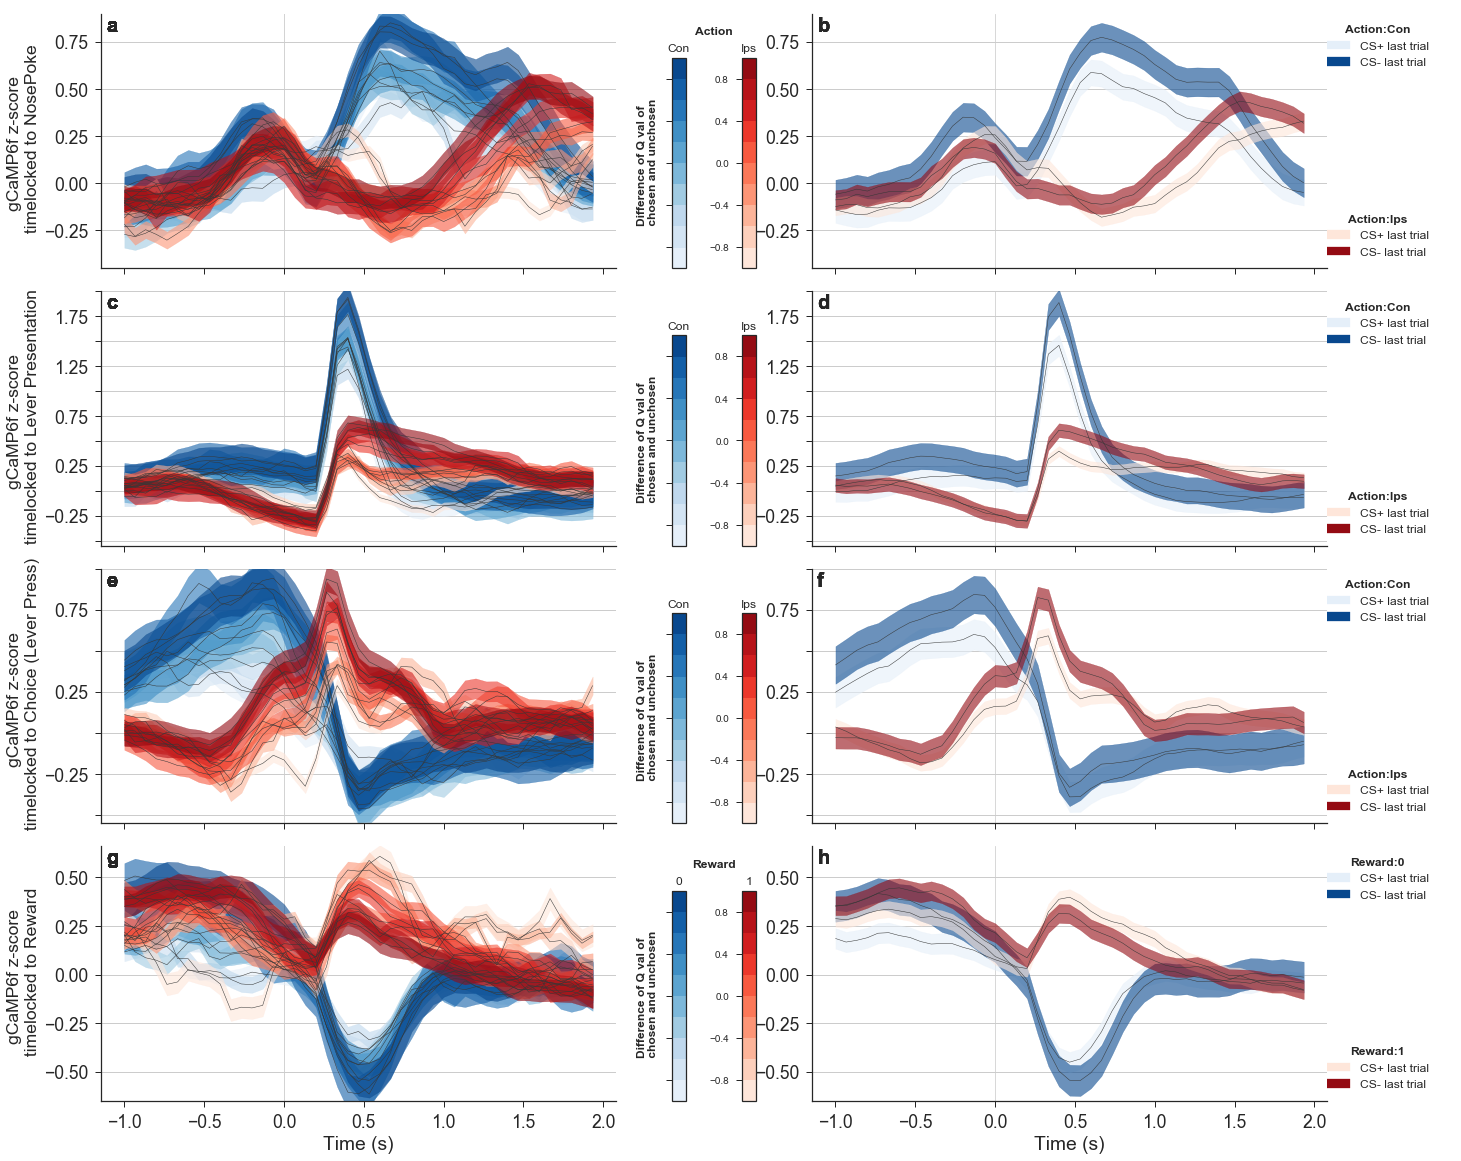

In [7]:
# RAW PLOT WITH LEGENDS 
sns.set_style('ticks')
Q_to_plot = 'Q_ch_diff'
Q_to_plot_name = 'Difference of Q val of \n chosen and unchosen'
ylims = [[-0.45, 0.9], [-0.55, 2.0], [-0.55, 1.0], [-0.65, 0.66]]
figure = plt.figure(figsize=(24, 20))
subfigs = np.array([['a', 'b'],['c', 'd'], ['e', 'f'], ['g', 'h']])
gs = gridspec.GridSpec(8, 5,
                       width_ratios=[9, 0.25, 0.25, 9, 1], height_ratios = [0.1, 1, 0.1, 1, 0.1, 1, 0.1, 1])

gs.update(wspace=0.25)

qlims = np.unique(df_corr['b' + Q_to_plot].dropna())
palettes =  ['Blues', 'Reds']

for j, [src, lines] in enumerate(zip(['qval', 'gcamp'], [qlims, np.arange(2)])):
    

    for i, [timelocked, tl_name] in enumerate(zip(['g_np', 'g_lp', 'g_choice', 'g_reward'], 
                                                           ['NosePoke', 'Lever Presentation', 'Choice (Lever Press)', 'Reward'])):

        if tl_name == 'Reward':
            categories = [0, 1]
            column = 'Reward'
        else:
            categories = ['Con', 'Ips']
            column = 'Action'
            
            

                                        
        # legend plotting 1. colorbar for the q values 
        if j == 0 and (i == 0 or i == 3):
            with sns.axes_style("white"):

                lax_title = plt.subplot(gs[i * 2, j + 1 : (j + 3)])
                lax_title.text(0.5, 0, column, size = 'xx-small', weight = 'bold', ha = 'center')

                lax_title.axis('off')
                
        
        
        lax2 = plt.subplot(gs[(i * 2): (i * 2 + 2), -1])

        for p_i, [subcat,palette] in enumerate(zip(categories, palettes)):
            color_palette = sns.color_palette(sns.color_palette(palette, len(qlims)))
  
            cmap = ListedColormap(color_palette.as_hex())
            bounds = [x.left for x in qlims] + [qlims[-1].right]
            norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = len(qlims))
            if j == 0:

                lax = plt.subplot(gs[i*2 + 1, j + 1 + p_i])
                dummy_plot = lax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
                lax.cla()
                cbar = plt.colorbar(dummy_plot, cax = lax)

                cbar.ax.set_title(subcat, size = 'xx-small')


                if p_i == 0:
                    cbar.ax.set_yticklabels([])
                    cbar.set_label(Q_to_plot_name, size =  12, weight = 'bold', labelpad=-50, y=0.5, rotation=90)
                if p_i == 1:
                    cbar.ax.tick_params(labelsize = 10)
#                     cbar.ax.tick_params(axis='y', direction='inout', left = False, right = True)
            if j == 1:
                ln1 = lax2.fill_between([],[],[], color = color_palette[0], label = 'CS+ last trial')
                ln2 = lax2.fill_between([],[],[], color = color_palette[-1], label = 'CS- last trial')
                
                lgd = plt.legend(handles = [ln1, ln2], fontsize = 'xx-small', loc= (p_i * 3 + 1), title = column + ':' + str(subcat)) #  bbox_to_anchor=(0.5,0.7))
                plt.setp(lgd.get_title(),fontsize='xx-small', weight = 'bold')

                if p_i == 0:
                    lax2.add_artist(lgd)

                lax2.axis('off')


        ax = plt.subplot(gs[i*2: (i * 2 + 2), j*3])


        for subcat_i, [subcat, palette] in enumerate(zip(categories, palettes)):
            df_src = df_corr[df_corr[column] == subcat]
            color_palette = sns.color_palette(sns.color_palette(palette, len(qlims)))


            for l_i, col in zip(lines, color_palette):

                # plot gcamps
                if src == 'qval':
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(df_src[(df_src[Q_to_plot] > l_i.left) & (df_src[Q_to_plot] <= l_i.right)][timelocked], 0)
                elif src == 'gcamp':
                    gcamp = np.vstack(df_src[(df_src['Reward_last'] == l_i)][timelocked])
                    x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
                    y = np.mean(gcamp, axis = 0)
                    col = color_palette[l_i * -1]

                error = np.std(y, axis = 0) / np.sqrt(NS)
                ax.plot(x, y, color = '#363737', linestyle = '-', linewidth = '0.5')
                ax.fill_between(x, y-error, y+error, color = col, alpha = 0.6)
                
                # title
#                 if i == 0:
#                     plt.title('GCaMP filtered with ' + src)

                # add subfig label
                ax.annotate(subfigs[i, j], (0,0), (0.01,0.99), 'axes fraction', fontsize=20,
                    weight='semibold', va='top', ha='left')
                
                # y axis 
                tick_interval = 0.25 
                ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
        
                plt.ylim(ylims[i])
                if i == 1 or i == 2: 
                    n = 2  # Keeps every nth label
                    [l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % n != 0]   
                if j == 0:
                    plt.ylabel('gCaMP6f z-score \n timelocked to ' + tl_name, size = 'small')

                # x axis 
                if i == 3:
                    plt.xlabel('Time (s)')
                else:
                    plt.xlabel('')
                    ax.xaxis.set_ticklabels([])
                
                # grid lines
                ax.yaxis.grid(True)
                ax.axvline(0, color = 'lightgray', alpha = 0.5, zorder = 0, lw = 0.8), # ls = ':'




# plt.tight_layout(w_pad = 0.001, h_pad = 0.2)
sns.despine()

# plt.savefig('figs/Fig1', dpi=180)
# plt.close()
# print('Done')


# Regression 

<ErrorbarContainer object of 3 artists>

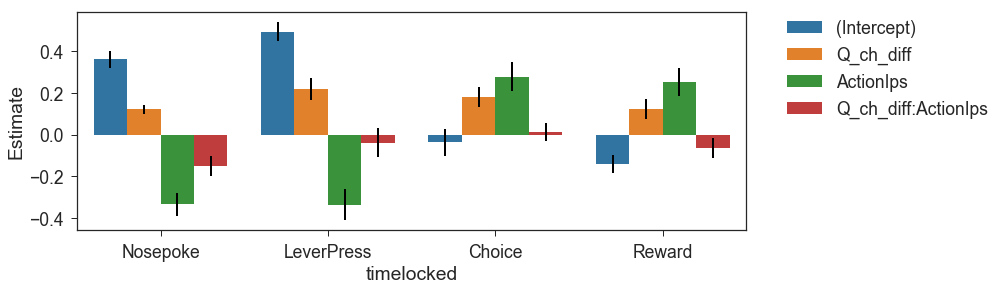

In [9]:
df = pd.read_csv('data/mm_reg_vals.csv')

plt.figure(figsize = (12, 4))
ax = plt.gca()
sns.barplot(data = df, x = 'timelocked', y = 'Estimate', hue = 'names')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.errorbar(x=np.delete(np.arange(-0.3, 3.4, 0.2), [4, 9, 14]), y=df.Estimate, yerr=df['Std. Error'], fmt = 'None', elinewidth = 2, ecolor = 'k')


# scrap

In [ ]:
ax  = plt.subplot2grid((1,1), (0, 0))
# col = sns.choose_diverging_palette(, QBINS = 10)
foo = sns.color_palette("mako", 13)[3:]
for subcat, line_type in zip(categories, ['-', ':']):
    df_src = df_corr[df_corr[column] == subcat]

    ax.plot([], 'k', linestyle = line_type, label = column + ":" + str(subcat))
    for q_i, col in zip(qlims, foo):
        x = np.arange(-LEN_BEFORE/15, LEN_AFTER/ 15, 1/15)
        y = np.mean(df_src[(df_src[Q_to_plot] > q_i.left) & (df_src[Q_to_plot] <= q_i.right)][timelocked], 0)
        error = np.std(y, axis = 0) / np.sqrt(NS)


        ax.plot(x, y, color = '#363737', linestyle = line_type)

        ax.fill_between(x, y-error, y+error, color = col, alpha = 0.8)
        plt.title('GCaMP timelocked at ' + tl_name + ' from ' + RECORDLOC)
        plt.ylabel('Normalized delta F/F')
        plt.xlabel('Time (s)')


In [ ]:
sns.palplot(['C0', 'C1'])

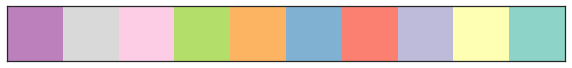

In [48]:
sns.palplot(sns.color_palette('Set3', 10)[::-1])

In [ ]:
sns.palplot(sns.color_palette("vlag", 13)[3:])

# mako, rocket, icefire, vlag 

In [ ]:
sns.choose_diverging_palette()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np; np.random.seed(1)

def make_ticklabels_invisible(fig):
    for i, ax in enumerate(fig.axes):
#         ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

        
fig = plt.figure(figsize=(8, 8))
outer_grid = gridspec.GridSpec(1, 1, wspace=0.0, hspace=0.0)


plot_grid = gridspec.GridSpecFromSubplotSpec(
      1, 10, subplot_spec=outer_grid[0], wspace=0.1, hspace=0.0)


plt_ax = plt.Subplot(fig, plot_grid[:9])
im = plt_ax.imshow(np.random.rand(5, 5))
plt_ax.set_xlabel("x label")
fig.add_subplot(plt_ax)


legend_grid = gridspec.GridSpecFromSubplotSpec(
      1, 2, subplot_spec=plot_grid[-1], wspace=0.1, hspace=0.0)

lax1 = plt.Subplot(fig, legend_grid[0])
fig.colorbar(im, cax=lax1)
fig.add_subplot(lax1)

lax2 = plt.Subplot(fig, legend_grid[1])
fig.colorbar(im, cax=lax2)
fig.add_subplot(lax2)


make_ticklabels_invisible(fig)


